# Kaggle - Toxic Comment Classification Challenge
# David Modjeska

In [59]:
import numpy as np
import pandas as pd
import re

from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier as XGBC

import tensorflow as tf
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, model_from_json

import pydot
import pydotplus
import graphviz

In [2]:
import multiprocessing
from joblib import Parallel, delayed

num_cores = int(multiprocessing.cpu_count() / 2)

In [3]:
%matplotlib inline

pd.set_option('display.max_colwidth', 200)

### Tools for Multiprocessing

In [4]:
id_separator = '__17TOKEN46__'

In [5]:
def my_function_wrapper(my_function, text, parameter_2 = None, parameter_3 = None):
        
    # remove row name as ID
    split_text = text.split(id_separator)
    id = split_text[0]
    value = split_text[1]
    
    # call the given function according to the correct number of parameters
    if parameter_3 is not None:
        result = my_function(value, parameter_2, parameter_3) 
    elif parameter_2 is not None:
        result = my_function(value, parameter_2) 
    else:
        result = my_function(value)     

    # add row name as ID
    combined_text = id + id_separator + str(result) # prepend row name as ID
    
    return(combined_text)

In [6]:
def my_do_func_parallel(data, my_function, value_field, parameter_2 = None, parameter_3 = None):
    
    # set row names as prefixes
    data_list_with_row_names = list(data.apply(lambda x: str(x.name) + id_separator + str(x[value_field]), axis = 1))

    # prepare progress bar
    inputs = tqdm(data_list_with_row_names)

    # execute the given function using multiprocessing
    if __name__ == "__main__":
        result = Parallel(n_jobs = num_cores)(delayed(my_function_wrapper)(my_function, value, parameter_2, parameter_3) 
                                              for value in inputs)
        
    # sort the results using row names as prefixes, and remove the prefixes
    result_df = pd.DataFrame(result, columns = {'result'})
    result_df[['row_name','text']] = result_df['result'].str.split(id_separator, expand = True)
    result_df['row_name'] = result_df['row_name'].astype(int)
    result_df = result_df.sort_values(by = 'row_name') \
        .drop({'result', 'row_name'}, axis = 1)
    
    return(result_df['text'].values)

## Load and Clean the Data

### Load the Data

In [7]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_labels = pd.read_csv('data/test_labels.csv')

In [8]:
train.shape

(159571, 8)

In [9]:
test.shape

(153164, 2)

In [10]:
test_labels.shape

(153164, 7)

In [11]:
train.isnull().sum().sum()

0

In [12]:
test.isnull().sum().sum()

0

In [13]:
test_labels.isnull().sum().sum()

0

In [14]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remo...",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tid...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [15]:
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

num_labels = len(label_columns)

In [16]:
scored_y_test_indices = test_labels['toxic'].apply(lambda x: x != -1)

test = test[scored_y_test_indices].reset_index(drop = True)
test_labels = test_labels[scored_y_test_indices].reset_index(drop = True)

print(test.shape)
print(test_labels.shape)

(63978, 2)
(63978, 7)


### Clean the Comments

In [17]:
def clean_comment(text, the_stopwords, remove_stopwords = True):
    
    output = ''
    
    comment = str(text).replace("\n", " ")
    comment = re.sub(r'[^\w]', ' ', comment).lower()
    comment = re.sub(r'[\s]+',' ', comment)
        
    if remove_stopwords:
        comment = comment.split(" ")
        for word in comment:
            if word not in the_stopwords:
                output += " " + word
    else:
        output = comment
        
    output = output.strip()
    return(output)

In [ ]:
the_stopwords = stopwords.words('English')

In [ ]:
train['comment_text_clean'] = my_do_func_parallel(train, clean_comment, 'comment_text', the_stopwords, False)

In [18]:
test['comment_text_clean'] = my_do_func_parallel(test, clean_comment, 'comment_text', the_stopwords, False)

In [19]:
# convert label values to numeric
train[label_columns] = train[label_columns].applymap(lambda x: pd.to_numeric(x))
test_labels[label_columns] = test_labels[label_columns].applymap(lambda x: pd.to_numeric(x))

In [20]:
X_train = train['comment_text_clean']
X_test = test['comment_text_clean']

y_train = train[label_columns].values
y_test = test_labels[label_columns].values

### Vectorize the Text

#### Define helper functions to get top features names

In [21]:
# from https://buhrmann.github.io/tfidf-analysis.html

def top_tfidf_features(row, features, top_n = 25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_features_in_doc(Xtr, features, row_id, top_n = 25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_features(row, features, top_n)

#### Vectorize Comments

In [22]:
vectorizer = TfidfVectorizer(max_df = 0.5, min_df = 0.0001, stop_words = 'english',
                                 use_idf = True, ngram_range = (1, 1), max_features = 10000)
vectorizer.fit(train['comment_text'])

X_train_tfidf = vectorizer.transform(train['comment_text'])
X_test_tfidf = vectorizer.transform(test['comment_text'])

In [23]:
X_train_all = X_train_tfidf
X_test_all = X_test_tfidf

In [24]:
y_train = train[label_columns]
y_test = test_labels[label_columns]

In [25]:
indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_n = 25
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['mitt', 'barbaro', 'foreskin', 'chand', 'dungeons', 'garrison', 'bauder', 'noes', 'orangemike', 'knob', 'tipler', 'truman', 'uruguay', 'cody', 'belle', 'jws', 'billcj', 'bail', 'wtc', 'yadavs', 'rexcurry', 'féin', '420', 'salvio', 'hazel']


In [26]:
len(features)

10000

## Classic Machine Learning - Ensemble

### Create the Component Models

In [27]:
xgbc = XGBC(n_jobs = num_cores, 
               eval_metric = 'logloss',
               use_label_encoder = False,
               n_estimators = 150, 
               max_depth = 8,
               learning_rate = 0.35)

In [28]:
log_reg = LogReg(C = 5,
                n_jobs = num_cores)

In [29]:
rfc = RFC(n_estimators = 300,
             max_depth = 1000,
             n_jobs = num_cores)

### Cross-validate the ensemble

In [30]:
all_ensembles = [None] * num_labels
print('TRAIN')
    
for i in range(num_labels):
    print('Label ' + str(i))
    this_ensemble = VotingClassifier(estimators = [('xgbc', xgbc), 
                                                   ('log_reg', log_reg), 
                                                   ('rfc', rfc)],
                                     voting = 'soft')
    this_ensemble.fit(X_train_all, y_train.iloc[:, i])
    all_ensembles[i] = this_ensemble

TRAIN
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5


In [31]:
all_cv_results = pd.DataFrame()
print('CV')

for i in range(num_labels):
    print('Label ' + str(i))
    
    these_cv_scores = cross_val_score(estimator = all_ensembles[i], 
                                     X = X_train_all, 
                                     y = y_train.iloc[:, i],
                                     cv = 3,
                                     n_jobs = num_cores)    
    these_cv_scores_mean = round(these_cv_scores.mean(), 4)

    this_cv_result = pd.DataFrame({ 'Label' : [label_columns[i]], 'Accuracy' : [these_cv_scores_mean] })        
    all_cv_results = pd.concat([all_cv_results, this_cv_result], axis = 0)

CV
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5


In [32]:
all_cv_results

,Label,Accuracy
0,toxic,0.9596
0,severe_toxic,0.9903
0,obscene,0.9805
0,threat,0.9973
0,insult,0.9722
0,identity_hate,0.9925


In [33]:
print(round(all_cv_results['Accuracy'].mean(), 4))

0.9821


### Generate the Test Predictions

In [34]:
all_roc_auc_scores = pd.DataFrame()
print('PREDICT')

for i in range(num_labels):
    print('Label ' + str(i))
    this_predict_proba = all_ensembles[i].predict_proba(X_test_all)
    
    this_roc_auc_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'ROC AUC' : [round(roc_auc_score(y_test.iloc[:, i], this_predict_proba[:, 1]), 4)]
    })
    all_roc_auc_scores = pd.concat([all_roc_auc_scores, this_roc_auc_score], axis = 0)

PREDICT
Label 0
Label 1
Label 2
Label 3
Label 4
Label 5


In [35]:
all_roc_auc_scores

,column,ROC AUC
0,toxic,0.9593
0,severe_toxic,0.9821
0,obscene,0.9711
0,threat,0.9835
0,insult,0.9651
0,identity_hate,0.9757


In [36]:
print(round(all_roc_auc_scores['ROC AUC'].mean(), 4))

0.9728


## Deep Learning - LSTM

*Adapted from https://towardsdatascience.com/classify-toxic-online-comments-with-lstm-and-glove-e455a58da9c7*

### Preparation

In [37]:
X_train_list = my_do_func_parallel(train, clean_comment, 'comment_text', the_stopwords, True)

In [38]:
X_test_list = my_do_func_parallel(test, clean_comment, 'comment_text', the_stopwords, True)

In [39]:
MAX_NB_WORDS = 10000    # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe) 

In [40]:
def prepare_data_for_learning(X_list, y, tokenizer = None):
    
    if tokenizer is None:
        tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
        tokenizer.fit_on_texts(X_list)
    
    sequences = tokenizer.texts_to_sequences(X_list)
    word_index = tokenizer.word_index
    
    print('Vocabulary size:', len(word_index))
    print('')

    data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)

    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', y.shape)
    
    return(sequences, word_index, data, tokenizer)

In [41]:
sequences, word_index, prepared_data_train, tokenizer = prepare_data_for_learning(X_train_list, y_train)

Vocabulary size: 186486

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [42]:
indices = np.arange(prepared_data_train.shape[0])
np.random.shuffle(indices)

data = prepared_data_train[indices]
labels = y_train.iloc[indices, :]

In [43]:
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train_dl = data[: -num_validation_samples]
y_train_dl = labels[: -num_validation_samples]

X_val_dl = data[-num_validation_samples: ]
y_val_dl = labels[-num_validation_samples: ]

In [44]:
print('Number of entries in each category:')
print('training: ', y_train_dl.sum(axis = 0))
print('validation: ', y_val_dl.sum(axis = 0))

Number of entries in each category:
training:  toxic            12204
severe_toxic      1294
obscene           6814
threat             381
insult            6328
identity_hate     1149
dtype: int64
validation:  toxic            3090
severe_toxic      301
obscene          1635
threat             97
insult           1549
identity_hate     256
dtype: int64


#### Data Sample

In [45]:
sample_record_number = 11

print('Tokenized sentences: \n', data[sample_record_number])
print('')
print('One hot label: \n', labels.iloc[sample_record_number, :])

Tokenized sentences: 
 [ 449   53  135  268    4    3   35 1229  488 1035    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    

In [46]:
GLOVE_DIR = "/Volumes/MY_PERM/Dev/Tools/GloVe/glove.6B/glove.6B." + str(EMBEDDING_DIM) + "d.txt"

In [47]:
embeddings_index = {}
file = open(GLOVE_DIR)

print('Loading GloVe from:', GLOVE_DIR,'...', end = '')
for line in file:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype = 'float32')
file.close()
print("Done.\n Proceeding with Embedding Matrix...", end = "")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print(" Completed")

Loading GloVe from: /Volumes/MY_PERM/Dev/Tools/GloVe/glove.6B/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


### Learning

In [48]:
sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype = 'int32')

embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable = False,
                           name = 'embeddings')

embedded_sequences = embedding_layer(sequence_input)

In [49]:
x = LSTM(units = 60, return_sequences = True, name = 'lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)

preds = Dense(units = num_labels, activation = "sigmoid")(x)

In [50]:
model = Model(sequence_input, preds)

model.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          18648700  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

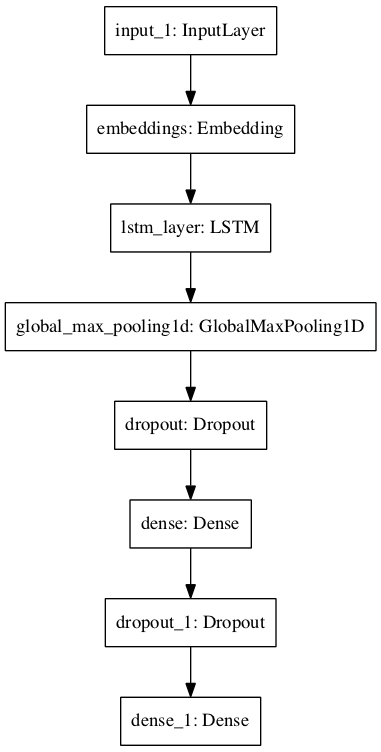

In [51]:
tf.keras.utils.plot_model(model)

In [52]:
print('Training progress:')

Training progress:


In [53]:
history = model.fit(X_train_dl, y_train_dl, epochs = 2, batch_size = 32, validation_data = (X_val_dl, y_val_dl))

Epoch 1/2
3990/3990 [==============================] - 256s 64ms/step - loss: 0.0891 - accuracy: 0.8929 - val_loss: 0.0537 - val_accuracy: 0.9944
Epoch 2/2
3990/3990 [==============================] - 244s 61ms/step - loss: 0.0539 - accuracy: 0.9881 - val_loss: 0.0494 - val_accuracy: 0.9944


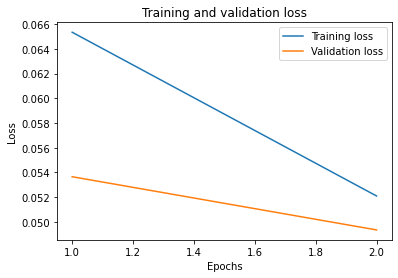

In [60]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show();

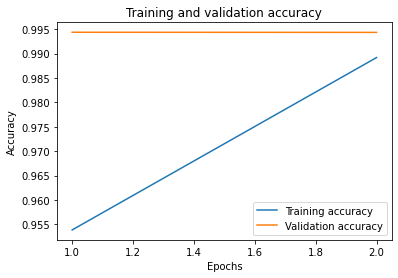

In [61]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show();

In [62]:
# serialize model to JSON

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")

print("Saved model to disk")

Saved model to disk


### Prediction

In [71]:
# load JSON and create model

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")

print("Loaded model from disk")

Loaded model from disk


In [72]:
sequences_test, word_index_test, prepared_data_test, _ = prepare_data_for_learning(X_test_list, y_test, tokenizer)

Vocabulary size: 186486

Shape of data tensor: (63978, 200)
Shape of label tensor: (63978, 6)


In [73]:
x_test_dl = prepared_data_test

In [74]:
predict_prob_test_dl = loaded_model.predict(x_test_dl) 

In [75]:
all_scores_dl = pd.DataFrame()

for i in range(num_labels):
    this_score = pd.DataFrame({
        'column' : [label_columns[i]], 
        'ROC AUC' : [round(roc_auc_score(y_test.iloc[:, i], predict_prob_test_dl[:, i]), 4)]
    })
    
    all_scores_dl = pd.concat([all_scores_dl, this_score], axis = 0)

all_scores_dl.reset_index(drop = True, inplace = True)

In [79]:
all_scores_dl

,column,ROC AUC
0,toxic,0.9575
1,severe_toxic,0.9876
2,obscene,0.9720
3,threat,0.9793
4,insult,0.9645
5,identity_hate,0.9749


In [76]:
print(round(all_scores_dl['ROC AUC'].mean(), 4))

0.9726
